In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#pip install -U scikit-learn
#from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression

In [3]:
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
nome_arq = 'Dados Titanic -  IA.xlsx'

In [6]:
df = pd.read_excel(nome_arq)
df.head(3)

,Passageiro,Sobrevivente,Classe,Nome,Sexo,Idade,Irmãos,Pais,Tarifa
0,1,0,3,"Braund, Mr. Owen Harris",masculino,22.0,1,0,7.25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",feminino,38.0,1,0,712833.00
2,3,1,3,"Heikkinen, Miss. Laina",feminino,26.0,0,0,7925.00


In [5]:
#df['Sexo'] = df.Sexo.map({'masculino':0, 'feminino':1}).astype(int)

In [7]:
df_quant = pd.concat([df.iloc[:,:3], df.iloc[:,4:]], axis=1)  # variaveis de interesse
df_quant.columns

Index(['Passageiro', 'Sobrevivente', 'Classe', 'Sexo', 'Idade', 'Irmãos',
       'Pais', 'Tarifa'],
      dtype='object')

In [8]:
Sexo = pd.get_dummies(df_quant.Sexo, drop_first=True)
df_quant.drop(columns='Sexo', inplace=True)
df_quant = pd.concat([df_quant, Sexo], axis= 1)

In [9]:
df_quant.head(2)

,Passageiro,Sobrevivente,Classe,Idade,Irmãos,Pais,Tarifa,masculino
0,1,0,3,22.0,1,0,7.25,1
1,2,1,1,38.0,1,0,712833.00,0


In [18]:
df_data = df_quant.drop(columns = 'Sobrevivente') # target
df_data.columns

Index(['Passageiro', 'Classe', 'Idade', 'Irmãos', 'Pais', 'Tarifa',
       'masculino'],
      dtype='object')

In [19]:
# target
y = df.iloc[:,1]
y_df = df[['Sobrevivente']]
y.name

'Sobrevivente'

## Análise de Correlação

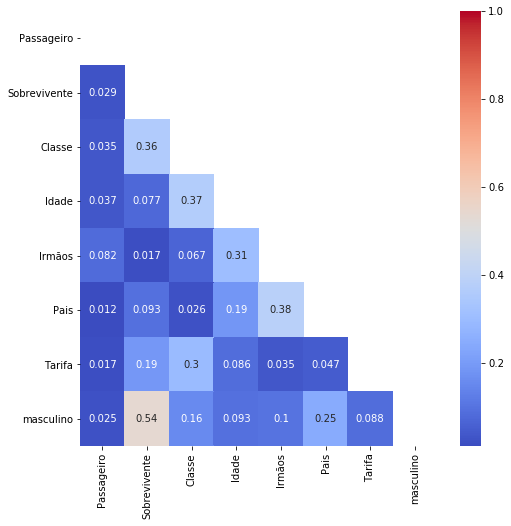

In [12]:
fig, ax = plt.subplots(figsize=(8, 8)) 
mask = np.zeros_like(df_quant.corr().abs())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(df_quant.corr().abs(), mask= mask, ax= ax, cmap='coolwarm', annot= True)

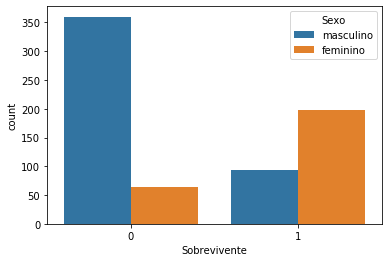

In [13]:
sns.countplot('Sobrevivente', hue = 'Sexo', data=df)

In [20]:
X = df_data.values
y = y.values

In [21]:
# instanciar
lr = LogisticRegression()
#lr.fit(X_train, y_train)
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
F, p_value = feature_selection.f_regression(X, y)

In [24]:
d_df = {'coef':list(lr.coef_[0]), 'F': list(F), 'p_value': list(p_value)}
dfr = pd.DataFrame(d_df, index = df_data.columns)
dfr.loc[dfr.p_value < 0.05, 'significativo'] = True
dfr

,coef,F,p_value,significativo
Passageiro,0.000089,0.613450,4.337524e-01,NaN
Classe,-0.002304,105.779868,3.162104e-23,True
Idade,-0.019752,4.271195,3.912465e-02,True
Irmãos,-0.000333,0.214599,6.433277e-01,NaN
Pais,0.000189,6.254607,1.261065e-02,True
Tarifa,0.000002,26.773741,2.977531e-07,True
masculino,-0.001616,291.287485,5.224710e-55,True


In [25]:
print(f'Score: {lr.score(X,y)}')

Score: 0.65406162464986


## Escolha das variáveis

In [26]:
colunas = ['Classe', 'masculino', 'Idade', 'Irmãos']
df_data = df_quant[colunas]
df_data.columns

Index(['Classe', 'masculino', 'Idade', 'Irmãos'], dtype='object')

In [27]:
X = df_data.values
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# valores preditos de y
y_pred = lr.predict(X)

In [31]:
F, p_value = feature_selection.f_regression(X, y)

In [32]:
def signif(p):
    if  p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'not'

In [33]:
d_df = {'coef':list(lr.coef_[0]), 'F': list(F), 'p_value': list(p_value)}
dfr = pd.DataFrame(d_df, index = df_data.columns)
dfr['significativo'] = dfr['p_value'].map(signif)                  # aplica função a uma Series
#dfr['chance'] = dfr.coef.map(chance)
#dfr['chance'] = dfr.coef.map(lambda ele: math.exp(ele))
dfr['chance'] = pd.Series(np.exp(dfr.coef.values), df_data.columns)
dfr['1/chance'] = 1 / dfr.chance
dfr

,coef,F,p_value,significativo,chance,1/chance
Classe,-1.274194,105.779868,3.162104e-23,***,0.279656,3.575816
masculino,-2.500149,291.287485,5.224710e-55,***,0.082073,12.184310
Idade,-0.043157,4.271195,3.912465e-02,*,0.957761,1.044102
Irmãos,-0.355041,0.214599,6.433277e-01,not,0.701144,1.426240


In [36]:
d_df = {'Features': [colunas],'Accuracy':metrics.accuracy_score(y, y_pred), 'F1-Score': metrics.f1_score(y, y_pred)}
dfs = pd.DataFrame(d_df, index = ['score'])
dfs

,Features,Accuracy,F1-Score
score,"[Classe, masculino, Idade, Irmãos]",0.808123,0.755793


## Fazendo a divisão entre base de treinamento e teste

In [74]:
nr_testes = 0

In [75]:
modelo = 'logist regression'

In [39]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
# valores preditos de y
y_pred = lr.predict(X_test)

In [76]:
a_modelo0 = np.array([modelo, metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)])

In [77]:
if nr_testes == 0: 
    a_modelo = a_modelo0
else:    
    a_modelo = np.append(a_modelo, a_modelo0)

In [78]:
modelos = pd.DataFrame(a_modelo.reshape(int(a_modelo.shape[0]/3),3), columns = ['Modelo', 'Accuracy', 'F1-Score'])
nr_testes = modelos.shape[0]
modelos

,Modelo,Accuracy,F1-Score
0,logist regression,0.7552447552447552,0.6391752577319588


___
# **DECISION TREE**
> Decision Trees possuem estrutura em forma de árvores.

* **Principais Vantagens**:
    * São algoritmos fáceis de entender, visualizar e interpretar;
    * Captura facilmente padrões não-lineares presentes nos dados;
    * Requer pouco poder computacional;
    * Lida bem com COLUNAS numéricas ou categóricas;
    * Não requer os dados sejam normalizados;
    * Pode ser utilizado como Feature Engineering ao lidar com Missing Values;
    * Pode ser utilizado como Feature Selection;
    * Não requer suposições sobre a distribuição dos dados por causa da natureza não-paramétrica do algoritmo

* **Principais desvantagens**
    * Propenso a Overfitting, pois Decision Trees podem construir árvores complexas que não sejam capazes de generalizar bem os dados. As coisas complicam muito se a amostra de treinamento possuir outliers. Portanto, **recomenda-se fortemente a tratar os outliers previamente**.
    * Pode criar árvores viesadas se tivermos um dataframe não-balanceado ou que alguma classe seja dominante. Por conta disso, **recomenda-se balancear o dataframe previamente para se evitar esse problema**.

* **Principais parâmetros**
    * Gini Index - é uma métrica que mede a frequência com que um ponto/observação aleatoriamente selecionado seria incorretamente identificado.
        * Portanto, quanto menor o valor de Gini Index, melhor a COLUNA;
    * Entropy - é uma métrica que mede aleatoriedade da informação presente nos dados.
        * Portanto, quanto maior a entropia da COLUNA, pior ela se torna para nos ajudar a tomar uma conclusão (classificar, por exemplo).

## **Referências**:
* [1.10. Decision Trees](https://scikit-learn.org/stable/modules/tree.html).
* [Decision Tree Algorithm With Hands On Example](https://medium.com/datadriveninvestor/decision-tree-algorithm-with-hands-on-example-e6c2afb40d38) - ótimo tutorial para aprender, entender, interpretar e calcular os índices de Gini e entropia.
* [Intuitive Guide to Understanding Decision Trees](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-decision-trees-adb2165ccab7) - ótimo tutorial para aprender, entender, interpretar e calcular os índices de Gini e entropia.
* [The Complete Guide to Decision Trees](https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14)
* [Creating and Visualizing Decision Tree Algorithm in Machine Learning Using Sklearn](https://intellipaat.com/blog/decision-tree-algorithm-in-machine-learning/) - Muito didático!
* [Decision Trees in Machine Learning](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052)

In [87]:
modelo = 'Decision Tree'

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [90]:
y_pred = dt_model.predict(X_test)

In [91]:
a_modelo0 = np.array([modelo, metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)])

In [92]:
if nr_testes == 0: 
    a_modelo = a_modelo0
else:    
    a_modelo = np.append(a_modelo, a_modelo0)

In [93]:
modelos = pd.DataFrame(a_modelo.reshape(int(a_modelo.shape[0]/3),3), columns = ['Modelo', 'Accuracy', 'F1-Score'])
nr_testes = modelos.shape[0]
modelos

,Modelo,Accuracy,F1-Score
0,logist regression,0.7552447552447552,0.6391752577319588
1,Decision Tree,0.7552447552447552,0.6391752577319588
2,Decision Tree,0.7552447552447552,0.6391752577319588


___
# **RANDOM FOREST**
* Decision Trees possuem estrutura em forma de árvores.
* Random Forest pode ser utilizado tanto para classificação (RandomForestClassifier)quanto para Regressão (RandomForestRegressor).

* **Vantagens**:
    * Não requer tanto data preprocessing;
    * Lida bem com COLUNAS categóricas e numéricas;
    * É um Boosting Ensemble Method (pois constrói muitas árvores). Estes modelos aprendem com os próprios erros e ajustam as árvores de modo a fazer melhores classificações;
    * Mais robusta que uma simples Decision Tree. **Porque?**
    * Controla automaticamente overfitting (**porque?**) e frequentemente produz modelos muito robustos e de alta-performance.
    * Pode ser utilizado como Feature Selection, pois gera a matriz de importância dos atributos (importance sample). A soma das importâncias soma 100;
    * Assim como as Decision Trees, esses modelos capturam facilmente padrões não-lineares presentes nos dados;
    * Não requer os dados sejam normalizados;
    * Lida bem com Missing Values;
    * Não requer suposições (assumptions) sobre a distribuição dos dados por causa da natureza não-paramétrica do algoritmo

* **Desvantagens**
    * **Recomenda-se balancear o dataframe previamente para se evitar esse problema**.

* **Principais parâmetros**

## **Referências**:
* [Running Random Forests? Inspect the feature importances with this code](https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e)
* [Feature importances with forests of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
* [Understanding Random Forests Classifiers in Python](https://www.datacamp.com/community/tutorials/random-forests-classifier-python)
* [Understanding Random Forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)
* [An Implementation and Explanation of the Random Forest in Python](https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76)
* [Random Forest Simple Explanation](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d)
* [Random Forest Explained](https://www.youtube.com/watch?v=eM4uJ6XGnSM)
* [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) - Explica os principais parâmetros do Random Forest.

In [102]:
modelo = 'Random Forest'

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
rf= RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [100]:
y_pred = rf.predict(X_test)

In [103]:
a_modelo0 = np.array([modelo, metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)])

In [104]:
if nr_testes == 0: 
    a_modelo = a_modelo0
else:    
    a_modelo = np.append(a_modelo, a_modelo0)

In [105]:
modelos = pd.DataFrame(a_modelo.reshape(int(a_modelo.shape[0]/3),3), columns = ['Modelo', 'Accuracy', 'F1-Score'])
nr_testes = modelos.shape[0]
modelos

,Modelo,Accuracy,F1-Score
0,logist regression,0.7552447552447552,0.6391752577319588
1,Decision Tree,0.7552447552447552,0.6391752577319588
2,Decision Tree,0.7552447552447552,0.6391752577319588
3,Random Forest,0.7762237762237763,0.6981132075471698


In [101]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        89
           1       0.71      0.69      0.70        54

    accuracy                           0.78       143
   macro avg       0.76      0.76      0.76       143
weighted avg       0.77      0.78      0.78       143



___
# **XGBOOST (eXtreme Gradient Boosting)**
* XGBoost é uma melhoria de Gradient Boosting. As melhorias são em velocidade e performace, além de corrigir as ineficiências do GradientBoosting.
* Algoritmo preferido pelos Kaggle Grandmasters;
* Paralelizável;
* Estado-da-arte em termos de Machine Learning;

## Parâmetros relevantes e seus valores iniciais
Consulte [Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) para detalhes completos sobre os parâmetros, significado e etc.

* n_estimators = 100 (100 caso o dataframe for grande. Se o dataframe for médio/pequeno, então 1000) - É o número de árvores desejamos construir;
* max_depth= 3 - Determina quão profundo cada árvore pode crescer durante qualquer round de treinamento. Valores típicos no intervalo [3, 10];
* learning rate= 0.01 - Usado para evitar overfitting, intervalo: [0, 1];
* alpha (somente para problemas de Regressão) - L1 regularization nos pesos. Valores altos resulta em mais regularization;
* lambda (somente para problemas de Regressão) - L2 regularization nos pesos.
* colsample_bytree: 1 - porcentagem de COLUNAS usados por cada árvore. Alto valor pode causar overfitting;
* subsample: 0.8 - porcentagem de amostras usadas por árvore. Um valor baixo pode levar a overfitting;
* gamma: 1 - Controla se um determinado nó será dividido com base na redução esperada na perda após a divisão. Um valor mais alto leva a menos divisões.
* objective: Define a "loss function". As opções são:
    * reg:linear - Para resolver problemas de regressão;
    * reg:logistic - Para resolver problemas de classificação;
    * binary:logistic - Para resolver problemas de classificação com cálculo de probabilidades;

# Referências
* [How exactly XGBoost Works?](https://medium.com/@pushkarmandot/how-exactly-xgboost-works-a320d9b8aeef)
* [Fine-tuning XGBoost in Python like a boss](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)
* [Gentle Introduction of XGBoost Library](https://medium.com/@imoisharma/gentle-introduction-of-xgboost-library-2b1ac2669680)
* [A Beginner’s guide to XGBoost](https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7)
* [Exploring XGBoost](https://towardsdatascience.com/exploring-xgboost-4baf9ace0cf6)
* [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)
* [Ensemble Learning case study: Running XGBoost on Google Colab free GPU](https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101) - Recomendo
* [Predicting movie revenue with AdaBoost, XGBoost and LightGBM](https://towardsdatascience.com/predicting-movie-revenue-with-adaboost-xgboost-and-lightgbm-262eadee6daa)
* [Tuning XGBoost Hyperparameters with Scikit Optimize](https://towardsdatascience.com/how-to-improve-the-performance-of-xgboost-models-1af3995df8ad)
* [An Example of Hyperparameter Optimization on XGBoost, LightGBM and CatBoost using Hyperopt](https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e) - Interessante
* [XGBOOST vs LightGBM: Which algorithm wins the race !!!](https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d) - LightGBM tem se mostrado interessante.
* [From Zero to Hero in XGBoost Tuning](https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58) - Gostei
* [Build XGBoost / LightGBM models on large datasets — what are the possible solutions?](https://towardsdatascience.com/build-xgboost-lightgbm-models-on-large-datasets-what-are-the-possible-solutions-bf882da2c27d)
* [Selecting Optimal Parameters for XGBoost Model Training](https://towardsdatascience.com/selecting-optimal-parameters-for-xgboost-model-training-c7cd9ed5e45e) - Muito bom!
* [CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

In [2]:
pip --version

pip 19.3.1 from c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\pip (python 3.7)

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pip

  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [106]:
modelo = 'xgboost'

In [107]:
from xgboost import XGBClassifier

In [108]:
xgboost = XGBClassifier(n_estimators=1000)

In [109]:
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [110]:
y_pred = xgboost.predict(X_test)

In [112]:
a_modelo0 = np.array([modelo, metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)])

In [113]:
if nr_testes == 0: 
    a_modelo = a_modelo0
else:    
    a_modelo = np.append(a_modelo, a_modelo0)

In [114]:
modelos = pd.DataFrame(a_modelo.reshape(int(a_modelo.shape[0]/3),3), columns = ['Modelo', 'Accuracy', 'F1-Score'])
nr_testes = modelos.shape[0]
modelos

,Modelo,Accuracy,F1-Score
0,logist regression,0.7552447552447552,0.6391752577319588
1,Decision Tree,0.7552447552447552,0.6391752577319588
2,Decision Tree,0.7552447552447552,0.6391752577319588
3,Random Forest,0.7762237762237763,0.6981132075471698
4,xgboost,0.7412587412587412,0.6476190476190475


In [111]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80        89
           1       0.67      0.63      0.65        54

    accuracy                           0.74       143
   macro avg       0.72      0.72      0.72       143
weighted avg       0.74      0.74      0.74       143

